In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tables
import mplfinance as mpf
import my_afml_fncs as my_afml
from my_afml_fncs import dropLabels, movingAverageCrossover
from research import drop_label
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [124]:
volume_bars_df = pd.read_hdf("tick_data/bars/volume_bars_50000.h5", key="volume_bars")
# volume_bars_df.head()
# volume_bars_df.shape
volume_bars_df['bar_number'] = range(len(volume_bars_df))


In [125]:
volume_bars_df['time']=pd.to_datetime(volume_bars_df['time'])
volume_bars_df.set_index('time',inplace=True)
# vol=my_afml.get_daily_volatility(volume_bars_df.close)
# volume_bars_df.shape

In [126]:
# get daily volatilities
vol=my_afml.getDailyVol(volume_bars_df.close)
vol.mean()
# vol.shape

np.float64(0.0034068157607856507)

In [127]:
# 3.1(a) apply CUSUM filet usings daily vols
es_cusum_events=my_afml.getTEvents(volume_bars_df.close,vol.mean())
es_cusum_events.shape

(68,)

In [128]:
# 3.1(b) get the t1 vertical barriers, with 1-day
t1=my_afml.getVb(volume_bars_df.close,es_cusum_events)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 531 entries, 2024-11-15 06:02:46.580251 to 2024-12-19 20:47:23.570312
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               531 non-null    float64
 1   high               531 non-null    float64
 2   low                531 non-null    float64
 3   close              531 non-null    float64
 4   volume             531 non-null    int64  
 5   bar_number         531 non-null    int64  
 6   bar_number_change  530 non-null    float64
 7   time_change        530 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 53.5 KB


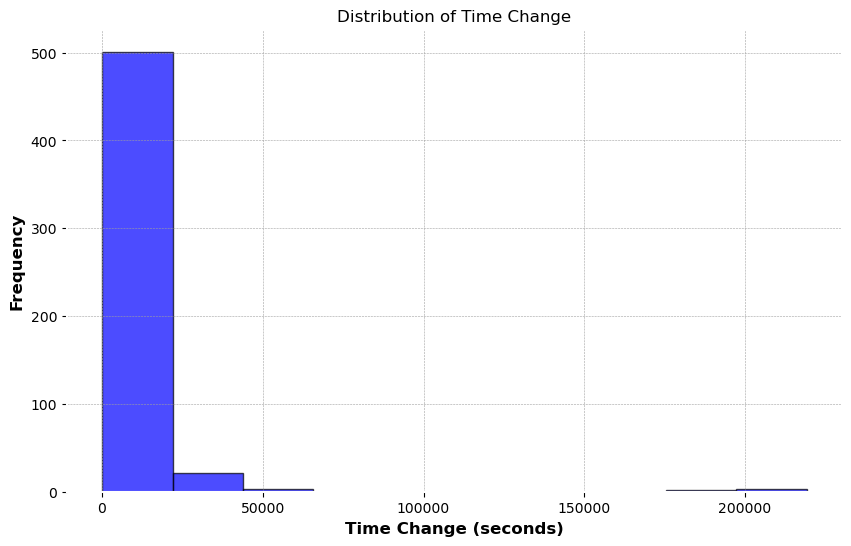

In [135]:
volume_bars_df.info()

# Calculate change in bar number and time
volume_bars_df['bar_number_change'] = volume_bars_df['bar_number'].diff()
volume_bars_df['time_change'] = volume_bars_df.index.to_series().diff().dt.total_seconds()

# Plot histogram of time changes
plt.figure(figsize=(10, 6))
plt.hist(volume_bars_df['time_change'].dropna(), bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Change')
plt.xlabel('Time Change (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




In [ ]:
# this is unrealted to 3.3, trgt, trigger and bins
# 3.1(c) apply triple barrier method on the data with ptsl [1,1] and t1 as above, i assume target is daily vol
ptsl=[1,1]
trgt=vol.mean()*volume_bars_df.close
minRet=0.00003
numThread=1
trigger=my_afml.getEvents(volume_bars_df.close,es_cusum_events,ptsl,trgt,minRet,numThread,t1)
# print(trigger)
# print(trigger.shape)

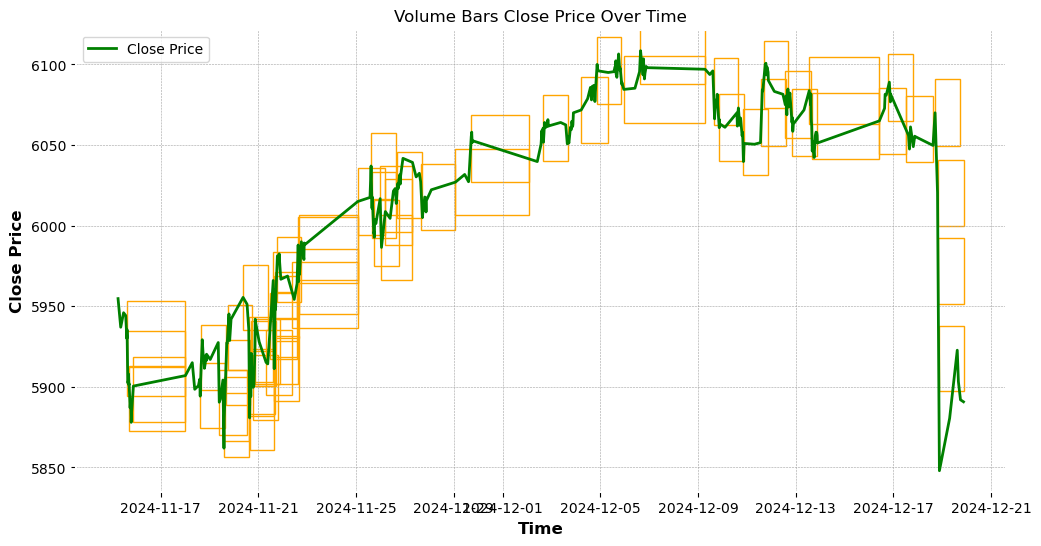

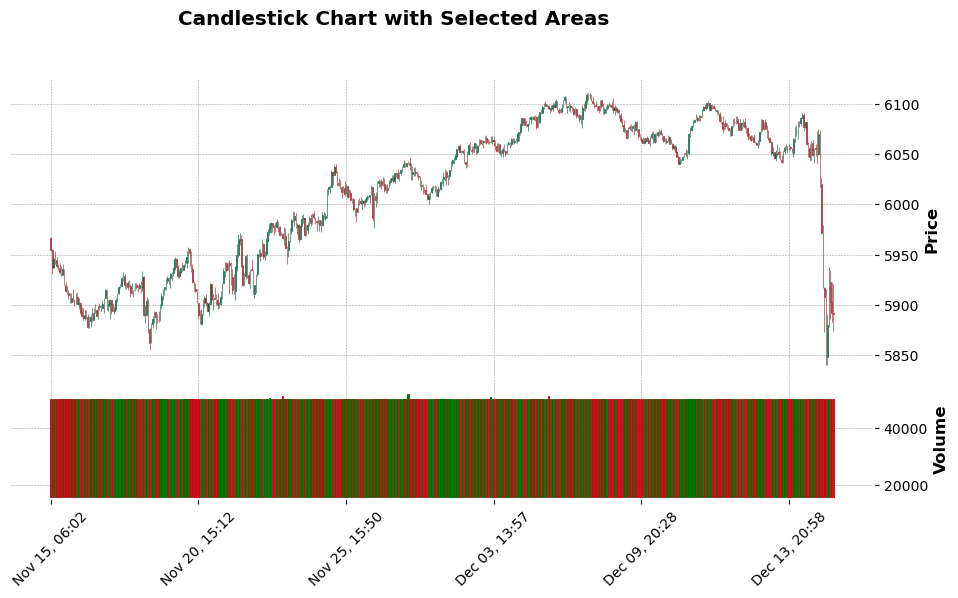

In [108]:
import mplfinance as mpf

plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='close', data=volume_bars_df, label='Close Price', color='green')

for start, t1, trgt in trigger.itertuples():
    box = Rectangle((start, volume_bars_df.close.loc[start] - vol.mean() * volume_bars_df.close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
# plt.legend()
plt.grid(True)
plt.show()

# New mplfinance plot
ap_boxes = []
for start, t1, trgt in trigger.itertuples():
    ap_boxes.append(mpf.make_addplot(
        [[volume_bars_df.close.loc[start],
          volume_bars_df.close.loc[start] + 2 * vol.mean() * volume_bars_df.close.loc[start]]],
        linestyle="dashed", color='orange'
    ))

mpf.plot(volume_bars_df, type='candle', style='charles', title='Candlestick Chart with Selected Areas',
          volume=True, figsize=(12, 6))



In [ ]:
# 3.1(d) apply getBins to generate labels
bins=my_afml.getBins(trigger,volume_bars_df.close)
# bins.head()

In [ ]:
# 3.2 drop rare labels
post_drop_bins=dropLabels(bins)
# post_drop_bins.head()

START OF MODEL FOR META_LABELS

In [ ]:
# Start of 3.3
# Define moving average windows
short_window = 5  # e.g., 50 periods
long_window = 20  # e.g., 200 periods

In [ ]:
# create events where the moving averages cross over
events = my_afml.movingAverageCrossover(volume_bars_df.close, short_window, long_window)
# events.head()
# try this with a crossover signa change
events['signal_switch'] = events.signal.diff() / 2
# drop rows with any NaN values
events = events.dropna()
# filter rows where signal_switch is not zero
events = events[events['signal_switch'] != 0]
events.head()

In [ ]:
volume_bars_df.close.shape

In [ ]:
# and add vertical barrier 1 day from those events (as close to 1 day as possible?)
t1=my_afml.getVb(volume_bars_df.close,events.index)

In [ ]:
# Now create the meta-labels using the primary model (which provides the side from the crossover point), the t1 vertical barrier which is as close to 1 day as possible from the crossover. We dont label anything as primary model as that was the simple crossover. Meta-labels are used to for secondary model.
# now set ptsl to be lopsided [1,2] which we can do because we now have a 'side' from the moving average crossover. Trigger has column called 'side'
ptsl=[1,2]
# target is set to be standard deviation
trgt=vol.mean()*volume_bars_df.close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
trigger_secondary_model=my_afml.getEvents(volume_bars_df.close,events.index,ptsl,trgt,minRet,numThread,t1,events.signal)


In [ ]:
trigger_secondary_model.head()

In [ ]:
# getBins will generate the meta-label as we provide a side now in trigger
bins_secondary_model=my_afml.getBins(trigger_secondary_model,volume_bars_df.close)

In [ ]:
bins_secondary_model.head()

In [ ]:
# add the crossover data and std to volume_bars for the secondary model
volume_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(volume_bars_df.close, short_window, long_window)
volume_bars_df['std']=my_afml.getDailyVol(volume_bars_df.close)
# volume_bars_df.head()


In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='close', data=volume_bars_df, label='Close Price', color='green')
sns.lineplot(x=volume_bars_df.index, y='short_ma', data=volume_bars_df, label='Short MA (5 periods)', color='blue')
sns.lineplot(x=volume_bars_df.index, y='long_ma', data=volume_bars_df, label='Long MA (20 periods)', color='red')

for start, t1, trgt, _ in trigger_secondary_model.itertuples():
    box = Rectangle((start, volume_bars_df.close.loc[start] - vol.mean() * volume_bars_df.close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
plt.xticks(rotation=45)
# plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# now fit same data using these labels
X=volume_bars_df.loc[bins_secondary_model.index,:]
y=bins_secondary_model['bin']

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
features = X
labels =y  # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

         0.0       0.50      0.75      0.60         4
         1.0       0.67      0.40      0.50         5

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9

